# TradingMotion Portfolios

Herramienta para analizar portfolios de estrategias TradingMotion SDK

Esta herramienta ha sido creada para ayudar a los participantes del concurso Robotrader (categoría TradingMotion)

In [214]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

#Imports varios
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
mpl.rcParams['figure.dpi']= 300
import sys, os
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import datetime
import numpy as np

import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Paired")

import empyrical as ep


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
pylab.rcParams['figure.figsize'] = 16, 6

## Definición del portfolio

El directorio _reports/_ debe contener los informes excel (exportados de la herramienta TradingMotion SDK Toolkit) de todos los sistemas que queramos incluir en el portfolio. 

Los definiremos en el siguiente format json:

```json
portfolio = {
    <ruta_fichero_informe_excel> : <multiplicador>
}
```

El parámetro **multiplicador** sirve para aumentar la exposición a la estrategia. Una estrategia con multiplicador 10, será incluida 10 veces en el portfolio

In [216]:
portfolio = {
    "reports/ES_60_min.xlsx": 6,
    "reports/URO_60_min.xlsx": 8,
    "reports/GC_60_min.xlsx": 14,
    "reports/RB_60_min.xlsx": 10,
    "reports/YM_60_min.xlsx": 16
}

## Construcción del portfolio combinado

In [217]:
# Cargamos los informes excel

df_sessionlogs = {}

for informe_path in portfolio:
    multiplicador = portfolio[informe_path]
    df = pd.read_excel(informe_path, 2, header=0, skiprows=2)
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
    df = df.set_index("Date").sort_index()[["Net P&L (USD)"]]
    df["Net P&L (USD)"] = df["Net P&L (USD)"] * multiplicador
    df_sessionlogs[informe_path] = df

In [218]:
# Los combinamos en un solo pandas dataframe para hacer el portfolio

df_portfolio = None

for informe_path in df_sessionlogs:
    if df_portfolio is None:
        df_portfolio = df_sessionlogs[informe_path]
        df_portfolio.columns = [informe_path]
    else:
        df_portfolio = df_portfolio.join(df_sessionlogs[informe_path].rename(columns={
            "Net P&L (USD)":informe_path
        })).fillna(0)
        
# Creamos la columna PORTFOLIO con el P&L combinado
df_portfolio["PORTFOLIO"] = df_portfolio.sum(axis=1)

In [219]:
# Visualizamos como ha quedado el dataframe combinado
df_portfolio.sample(5)

,reports/ES_60_min.xlsx,reports/URO_60_min.xlsx,reports/GC_60_min.xlsx,reports/RB_60_min.xlsx,reports/YM_60_min.xlsx,PORTFOLIO
Date,,,,,,
2017-04-21,-4499.149,1200.000,3360.000,10458.000,-3416.000,7102.851
2017-02-14,2700.000,-1600.000,4340.000,-42.000,7920.000,13318.000
2017-09-15,1800.000,-4054.900,-3125.219,-6405.634,4720.000,-7065.753
2016-03-01,14775.000,400.000,-9240.000,-8778.000,28320.000,25477.000
2016-05-19,1275.000,1350.000,5320.000,-2562.000,5920.000,11303.000


## Análisis del portfolio

El tamaño del portfolio (o Capital Sugerido en la terminología de TradingMotion), se puede calcular con la siguiente aproximación:

```
capital_sugerido = MAX( 3.6*peor_drawdown , 10*peor_sesion)
```

En otras palabras, tomaremos como capital sugerido el valor más grande entre 3.6 veces el peor drawdown y 10 veces la peor sesión

In [220]:
# Cálculo de peor sesión
peor_sesion = df_portfolio["PORTFOLIO"].min()

# Cálculo de peor drawdown
cumulative = df_portfolio["PORTFOLIO"].cumsum().values
max_return = np.fmax.accumulate(cumulative)

peor_drawdown = np.nanmin(cumulative - max_return)

# Cálculo de capital sugerido
capital_sugerido = abs(round(min(3.6*peor_drawdown,10*peor_sesion),0))

# Visualizamos el capital sugerido
df_estadisticas = pd.DataFrame.from_dict({
    "peor sesion": peor_sesion,
    "peor drawdown": peor_drawdown,
    "CAPITAL SUGERIDO": capital_sugerido
},"index")

df_estadisticas.columns = ["PORTFOLIO"]

df_estadisticas

,PORTFOLIO
peor sesion,-91996.427
peor drawdown,-269427.082
CAPITAL SUGERIDO,969937.000


In [221]:
# Calculamos el retorno diario absoluto
df_returns = (df_portfolio["PORTFOLIO"].cumsum() + capital_sugerido).pct_change().dropna()

In [222]:
# Mostramos otras métricas del portfolio
df_performance = pd.DataFrame.from_dict({
    "CAPITAL SUGERIDO": capital_sugerido,
    "TOTAL P&L": df_portfolio["PORTFOLIO"].cumsum().values[-1],
    "Sesiones Analizadas": len(df_portfolio),
    "Sesiones Ganadoras (%)": 100 * len(df_portfolio[df_portfolio["PORTFOLIO"]>0]) /  len(df_portfolio[df_portfolio["PORTFOLIO"]!=0]),
    "ROI Anualizado (%)": 100 * ep.annual_return(df_returns),
    "Volatilidad Anualizada (%)": 100 * ep.annual_volatility(df_returns),
    "Profit Factor":  df_returns[df_returns > 0].sum() / abs(df_returns[df_returns < 0].sum()),
    "Promedio Sesion Ganadora":  df_portfolio[df_portfolio["PORTFOLIO"] > 0]["PORTFOLIO"].mean(),
    "Promedio Sesion Perdedora":  df_portfolio[df_portfolio["PORTFOLIO"] < 0]["PORTFOLIO"].mean(),
    "Ratio Sharpe": ep.sharpe_ratio(df_returns),
    "Ratio Sortino": ep.sortino_ratio(df_returns),
},"index")

df_performance.columns = ["PORTFOLIO"]

df_performance

,PORTFOLIO
CAPITAL SUGERIDO,969937.000
TOTAL P&L,3761953.181
Sesiones Analizadas,815.000
Sesiones Ganadoras (%),56.984
ROI Anualizado (%),63.336
Volatilidad Anualizada (%),20.140
Profit Factor,1.621
Promedio Sesion Ganadora,21956.891
Promedio Sesion Perdedora,-18276.360
Ratio Sharpe,2.538


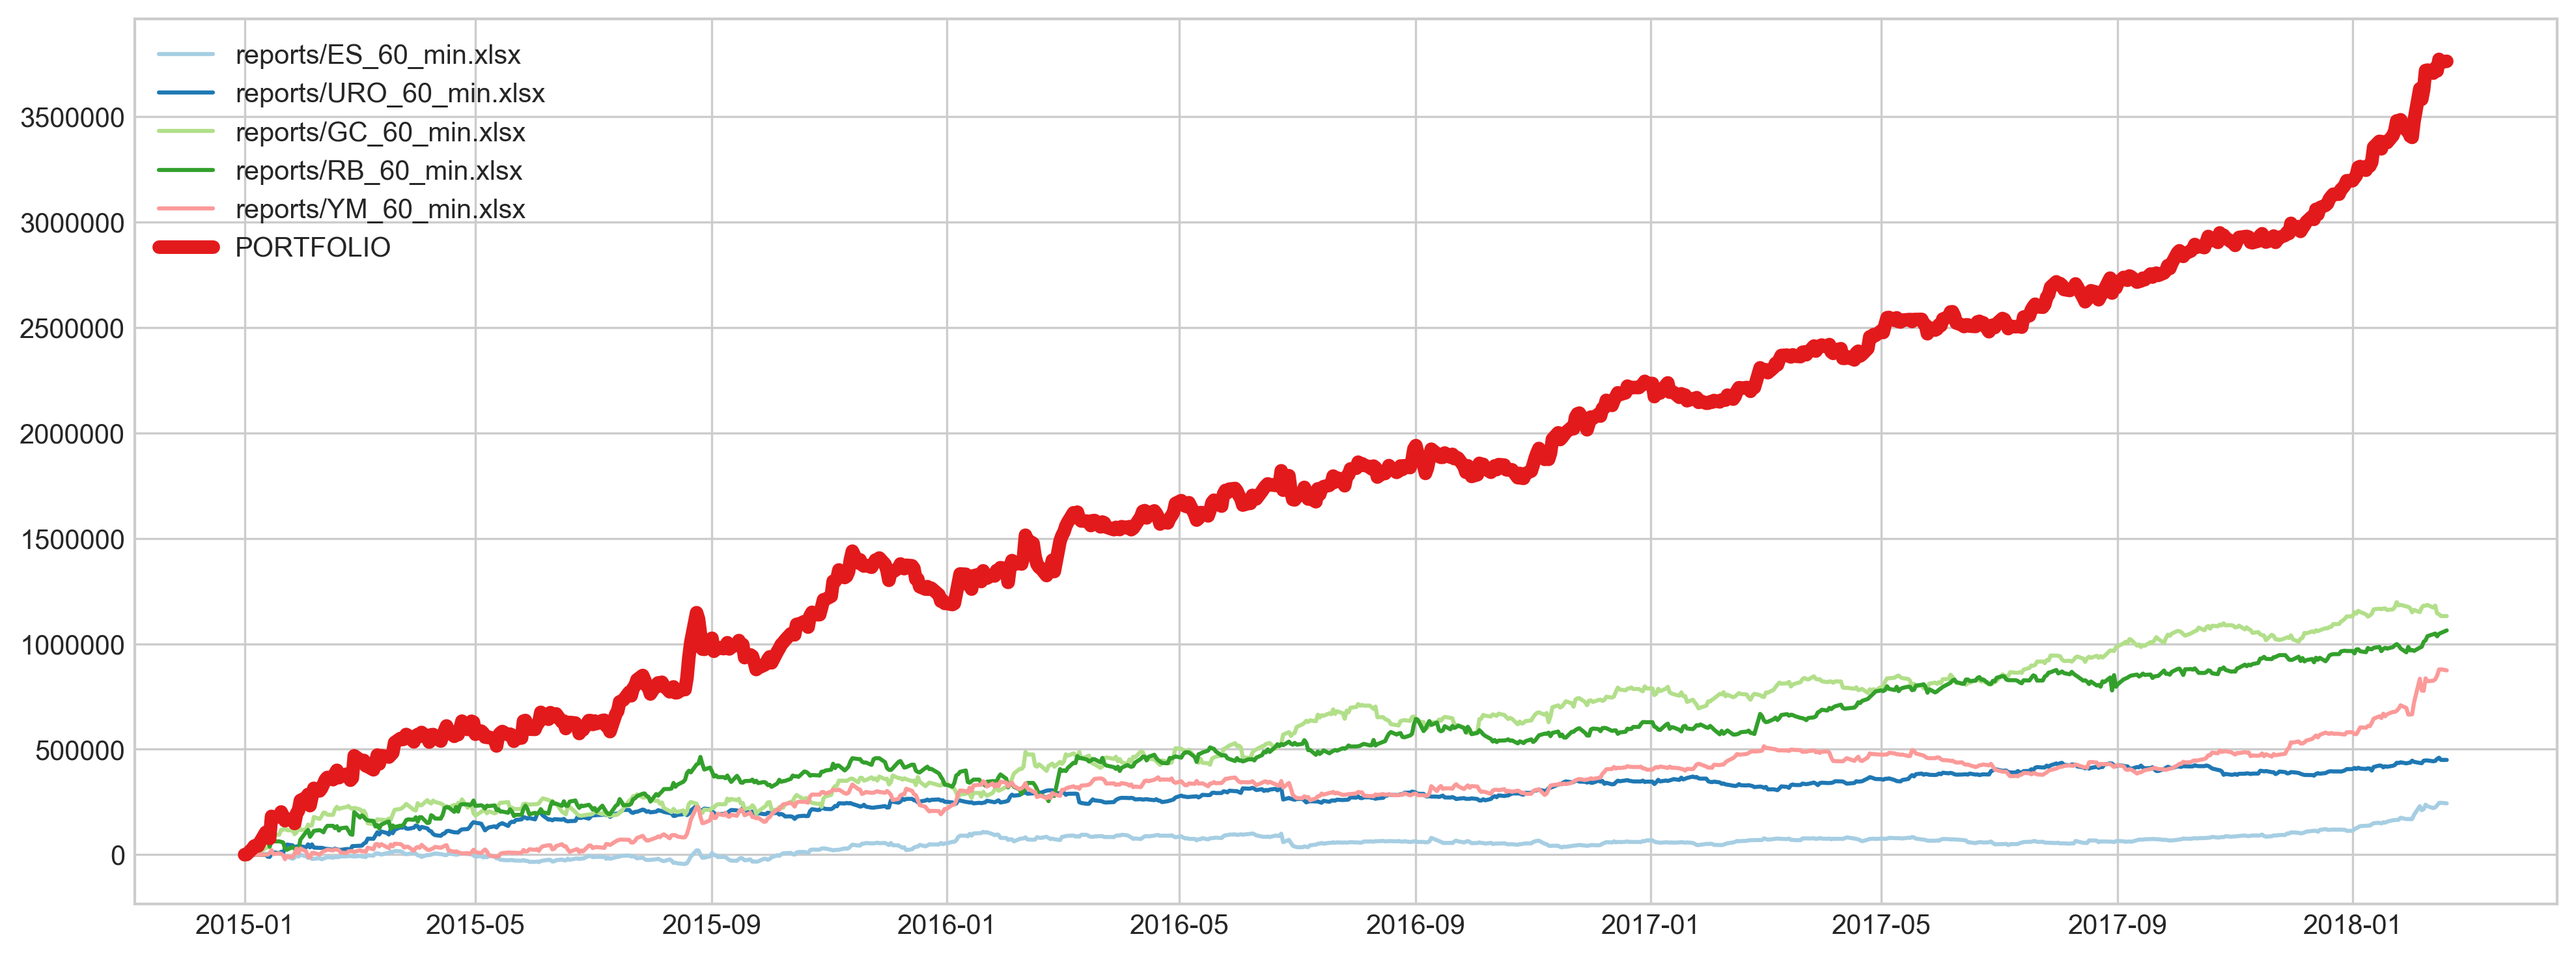

In [223]:
# Graficamos el portfolio
fig = plt.figure()

plt.plot(df_portfolio.drop("PORTFOLIO", axis=1).cumsum())
plt.plot(df_portfolio["PORTFOLIO"].cumsum(), linewidth=5);

leg = plt.legend(df_portfolio.columns.values)
plt.show()